# Imports

In [10]:
# imports
import os, sys

# filter filenames for .nii
import glob

# numpy
import numpy as np

# simple itk for dicom
import SimpleITK as sitk

# meshio for 3DSlicer segm obj
import meshio

# import sitk_gui

# helpers: segmentation,np2sitk conversion, misc
from helpers import seg2mask, get_roi_range, \
                    sitk2np, np2sitk, \
                    round_tuple, lrange

# viz helpers
from helpers_viz import viz_objs, viz_axis, np_alpha_blend

In [11]:
# auto-reload when local helper fns change
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Data

In [12]:
PROJ_PATH = "."

# Load train data
train_path = f"{PROJ_PATH}/train_data/train_data"

# Folders containing MR train data
train_folders = os.listdir(train_path)
print(f"Train data folders: {train_folders}")

# make a dictionary of key = train folder, value = (segm obj, nii file)
train_data_dict = {}
for folder in train_folders:
  segm_obj_path = os.path.join(train_path, folder, "Segmentation.obj")

  mp_path      = os.path.join(train_path, folder, "MP-RAGE")
  folder1_path = os.path.join(mp_path, os.listdir(mp_path)[0])
  folder2_path = os.path.join(folder1_path, os.listdir(folder1_path)[0])
  nii_path     = glob.glob(f"{folder2_path}/*.nii")[0] #os.path.join(folder2_path, os.listdir(folder2_path)[0])
  train_data_dict[folder] = (segm_obj_path, nii_path)
    
# print train data dict
print(f"Training data: key = train folder, value = full path to (segm obj, nii file)\n")
print(*list(train_data_dict.items()), sep="\n")

Train data folders: ['50455', '50458', '50461', '50456', '50463', '50459', '50457', '50462', '50460', '50464']
Training data: key = train folder, value = full path to (segm obj, nii file)

('50455', ('./train_data/train_data/50455/Segmentation.obj', './train_data/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii'))
('50458', ('./train_data/train_data/50458/Segmentation.obj', './train_data/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii'))
('50461', ('./train_data/train_data/50461/Segmentation.obj', './train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I329213.nii'))
('50456', ('./train_data/train_data/50456/Segmentation.obj', './train_data/train_data/50456/MP-RAGE/2000-01-01_00_00_00.0/S164657/ABIDE_50456_MRI_MP-RAGE_br_raw_20120830174547173_S164657_I328667.nii'))
('5

## Moving Image

In [13]:
# Get path to MR file

moving_folder = "50455"
moving_segm_path, moving_file = train_data_dict[moving_folder]

print(f"Folder: {moving_folder}, MR nii path: {os.path.basename(moving_file)}.")

# compile MR obj from nii file using Simple ITK reader
moving_obj        = sitk.ReadImage(moving_file)
moving_segm       = meshio.read(moving_segm_path)

print("#"*10, f"Moving", "#"*10)
print(f"mr vol shape: {moving_obj.GetSize()}")
print(f"mr vol spacing: {round_tuple(moving_obj.GetSpacing())}")
print(f"mr orientation: {round_tuple(moving_obj.GetDirection())}")

Folder: 50455, MR nii path: ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii.
########## Moving ##########
mr vol shape: (160, 480, 512)
mr vol spacing: (1.2, 0.5, 0.5)
mr orientation: (0.999, 0.023, -0.024, 0.023, -1.0, -0.001, 0.024, 0.0, 1.0)


### Moving Image Binary Mask

In [14]:
moving_mask_arr = seg2mask(moving_obj, moving_segm)

# see which slices contain ROI
print(f"ROI contains {np.count_nonzero(moving_mask_arr)} elements")
print(f"ROI non-zero range: ", get_roi_range(moving_mask_arr, axis=0))

ROI contains 60246 elements
ROI non-zero range:  (65, 93)


### Viz Moving Image + Mask

In [15]:
# see which slices contain ROI
print(f"ROI contains {np.count_nonzero(moving_mask_arr)} elements")
print(f"ROI non-zero range: ", get_roi_range(moving_mask_arr, axis=0))

ROI contains 60246 elements
ROI non-zero range:  (65, 93)


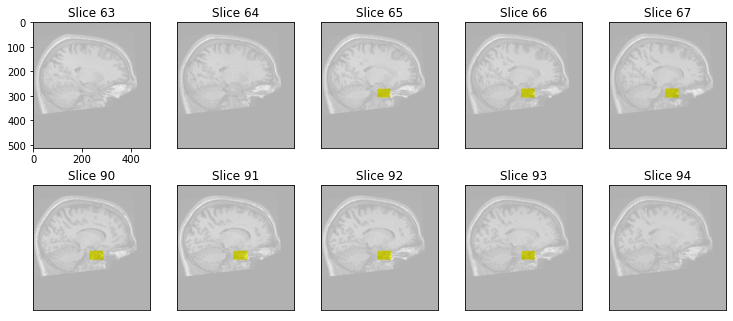

In [24]:
viz_axis(sitk2np(moving_obj), bin_mask_arr=moving_mask_arr, 
        slices=lrange(63, 68) + lrange(90,95), fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2, cmap0="gray")

## Fixed Image

In [17]:
# Get path to MR file

fixed_folder = "50456"
fixed_segm_path, fixed_file = train_data_dict[fixed_folder]

print(f"Folder: {fixed_folder}, MR nii path: {os.path.basename(fixed_file)}.")

# compile MR obj from nii file using Simple ITK reader
fixed_obj        = sitk.ReadImage(fixed_file)
fixed_segm       = meshio.read(fixed_segm_path)

print("#"*10, f"Fixed", "#"*10)
print(f"mr vol shape: {fixed_obj.GetSize()}")
print(f"mr vol spacing: {round_tuple(fixed_obj.GetSpacing())}")
print(f"mr orientation: {round_tuple(fixed_obj.GetDirection())}")

Folder: 50456, MR nii path: ABIDE_50456_MRI_MP-RAGE_br_raw_20120830174547173_S164657_I328667.nii.
########## Fixed ##########
mr vol shape: (160, 480, 512)
mr vol spacing: (1.2, 0.5, 0.5)
mr orientation: (1.0, -0.026, 0.0, -0.026, -1.0, 0.0, 0.0, 0.0, 1.0)


### Fixed Image Binary Mask

In [18]:
# get segm as np binary mask arr
fixed_mask_arr = seg2mask(fixed_obj, fixed_segm)

# see which slices contain ROI
print(f"ROI contains {np.count_nonzero(fixed_mask_arr)} elements")
print(f"ROI non-zero range: ", get_roi_range(fixed_mask_arr, axis=0))

ROI contains 43620 elements
ROI non-zero range:  (65, 90)


In [12]:
print(f"Fixed ROI non-zero range: ", get_roi_range(fixed_mask_arr, axis=0))
print(f"Moving ROI non-zero range: ", get_roi_range(moving_mask_arr, axis=0))

Fixed ROI non-zero range:  (65, 90)
Moving ROI non-zero range:  (65, 93)


# Overlay Moving and Fixed Image

In [22]:
fixed_arr  = sitk2np(fixed_obj)
moving_arr = sitk2np(moving_obj)

In [ ]:
full_blended_arr = np_alpha_blend(fixed_arr, moving_arr, mask1 = fixed_mask_arr, mask2 = moving_mask_arr)

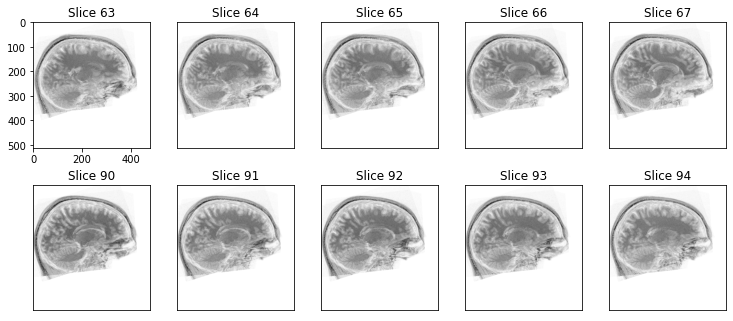

In [25]:
viz_axis(full_blended_arr,\
        slices=lrange(63, 68) + lrange(90,95), \
        fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2, cmap0="gray")

# Preprocess

## Isotropic

Source: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/05_Results_Visualization.html


In [29]:
iso_spacing      = (1,1,1)
iso_interpolator = sitk.sitkLinear # sitk.sitkBSline

In [34]:
# isotropic fixed and moving obj
iso_fixed_obj  = get_isotropic(fixed_obj,  new_spacing = iso_spacing, interpolator=iso_interpolator)
iso_moving_obj = get_isotropic(moving_obj, new_spacing = iso_spacing, interpolator=iso_interpolator)

# isotropic fixed and moving mask obj
iso_fixed_mask_obj  = get_isotropic(np2sitk(fixed_mask_arr, fixed_obj),  new_spacing = iso_spacing, interpolator=iso_interpolator)
iso_moving_mask_obj = get_isotropic(np2sitk(moving_mask_arr, moving_obj), new_spacing = iso_spacing, interpolator=iso_interpolator)

In [36]:
iso_fixed_mask_arr  = sitk2np(iso_fixed_mask_obj)
iso_moving_mask_arr = sitk2np(iso_moving_mask_obj)

print(f"Isotropic Fixed ROI non-zero range: ", get_roi_range(iso_fixed_mask_arr, axis=0))
print(f"Isotropic Moving ROI non-zero range: ", get_roi_range(iso_moving_mask_arr, axis=0))

Isotropic Fixed ROI non-zero range:  (78, 107)
Isotropic Moving ROI non-zero range:  (78, 111)


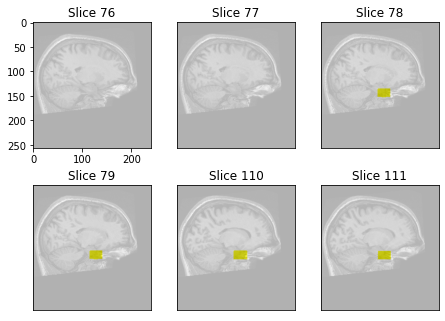

In [37]:
viz_axis(sitk2np(iso_moving_obj), bin_mask_arr=iso_moving_mask_arr, 
        slices=lrange(76, 80) + lrange(110,112), fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 3], hspace=0.3, fig_mult=2, cmap0="gray")

# Elastix Registration

## Rigid Alignment

- Rigid: "rigid body, which can translate and rotate, but cannot be
scaled/stretched."

- Similarity: "translate, rotate, and scale isotropically."

- Affine: "translated, rotated, scaled,
and sheared."

Source: 5.0.1 Elastix Manual

In [42]:
parameterMap = sitk.GetDefaultParameterMap('affine')

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(iso_fixed_obj)
elastixImageFilter.SetMovingImage(iso_moving_obj)
elastixImageFilter.SetParameterMap(parameterMap)
elastixImageFilter.Execute()

transformed_moving_obj  = elastixImageFilter.GetResultImage()
transformedParameterMap = elastixImageFilter.GetTransformParameterMap()

### Map ROI

Elastix convention: Resampling $moving \to fixed$ image involves a transformation $T: fixed \to moving$. $T$ maps coordinates in the fixed image domain to the corresponding coordinates in the moving image. Resampling a moving image onto the fixed image coordinate system involves:
1. Apply $T$ to fixed image voxel coordinates $x$ to get corresponding coordinates $y$ in the moving domain: $y = T(x) \in I_M$.
2. Estimate the voxel intensities $v$ at the moving image coordinates $y \in I_m$ via (linear) interpolation from nearby moving image voxel intensities.
3. Set the voxel intensities $v$ at the fixed image coordinates $x \in I_F$ to the above moving image voxel intensities.

In [60]:
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(transformedParameterMap)

transformixImageFilter.SetMovingImage(iso_moving_mask_obj)
transformixImageFilter.Execute()

transformed_moving_mask_obj = transformixImageFilter.GetResultImage()

In [71]:
# objs
print(f"Iso fixed obj shape: {iso_fixed_obj.GetSize()}. Iso fixed mask shape: {iso_fixed_mask_obj.GetSize()}")
print(f"Iso moving obj shape: {iso_moving_obj.GetSize()}. Iso moving mask shape: {iso_moving_mask_obj.GetSize()}")
# masks
print(f"Transformed mask obj shape: ", transformed_moving_mask_obj.GetSize())

Iso fixed obj shape: (192, 240, 256). Iso fixed mask shape: (192, 240, 256)
Iso moving obj shape: (192, 240, 256). Iso moving mask shape: (192, 240, 256)
Transformed mask obj shape:  (192, 240, 256)


### Viz Mapped ROI

In [72]:
transformed_moving_mask_arr = sitk2np(transformed_moving_mask_obj)
print(transformed_moving_mask_arr.shape)

(192, 240, 256)


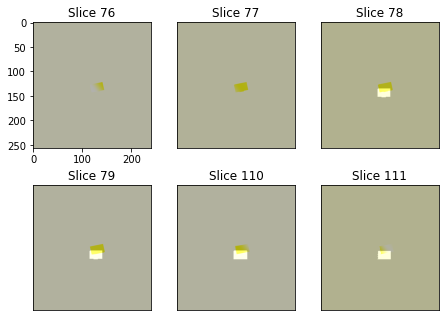

In [46]:
viz_axis(iso_moving_mask_arr, bin_mask_arr=transformed_moving_mask_arr, 
        slices=lrange(76, 80) + lrange(110,112), fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 3], hspace=0.3, fig_mult=2, cmap0="gray")

In [55]:
print(f"Isotropic Fixed ROI non-zero range: ", get_roi_range(iso_fixed_mask_arr, axis=0))
print(f"Isotropic Moving ROI non-zero range: ", get_roi_range(iso_moving_mask_arr, axis=0))
print(f"Transformed Moving ROI non-zero range: ", get_roi_range(transformed_moving_mask_arr.astype(bool), axis=0))

Isotropic Fixed ROI non-zero range:  (78, 107)
Isotropic Moving ROI non-zero range:  (78, 111)
Transformed Moving ROI non-zero range:  (0, 190)


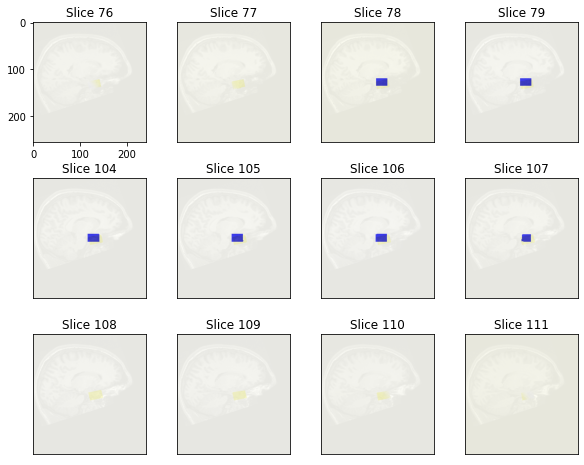

In [79]:
#cmap1 = [white, yellow]; cmap2 = [white, blue]
viz_axis(sitk2np(iso_fixed_obj), \
        bin_mask_arr=transformed_moving_mask_arr, \
        bin_mask_arr2=iso_fixed_mask_arr, \
        slices=lrange(76, 80) + lrange(104,112), fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [3, 4], hspace=0.3, fig_mult=2, cmap0="gray")